In [ ]:
#conda env export > environment.yml

replace contractions/location abbreviations via dictionary
denoise text/apply word segmentation
create word count dictionary
next, spell check:
add to dictionary from reoccuring words in text? or use freq dict symspell
apply spell check to words in word count dictionary occuring only one time
apply pos tag to tweets creating new column
lemmatize tweets based on pos tag column
bigrams with Phraser

In [1]:
import os
import re
import string
import pandas as pd 
import itertools

## import datasets

In [429]:
# import dataset
train = pd.read_csv('train.csv', usecols=['text', 'keyword', 'location'])
test = pd.read_csv('test.csv', usecols=['text', 'keyword', 'location'])
target = pd.read_csv('train.csv', usecols=['target'])

In [430]:
print(len(train))

7613


In [431]:
print(len(test))

3263


In [432]:
df = train.append(test)

In [487]:
len(df)

10876

## visualize target data

#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text', 'location', 'keyword'], keep='first', inplace=True)
#test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(len(df))
#print(len(test_df))

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

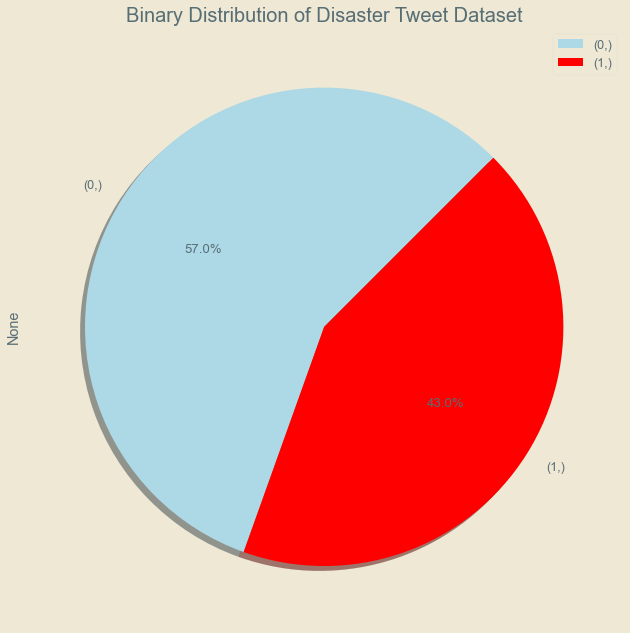

In [31]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

In [7]:
from symspellpy.symspellpy import SymSpell, Verbosity
from spellchecker import SpellChecker
import pkg_resources

## hashtags

In [588]:

# functions related to expanded hashtags in text
def pascal_case_split(text):
    # expand hashtags formatted in pascal case, ex: #ThisIsPascal
    for word in text:
        if word.startswith('#'):
            return re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)

def camel_case_split(text):
    # expand hashtags formatted in pascal case, ex: #thisIsCamel
    for word in text:
        if word.startswith('#'):
            return re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)

def spell_check_word(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.TOP, include_unknown=True)
    closest = corrections[0]
    # display suggestion term, edit distance, and term frequency
    return closest.term
    
def spell_check_words(word):
    # lookup suggestions for multi word string input
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    corrections = spell.lookup_compound(word, max_edit_distance=2)
    closest = corrections[0]
# display suggestion term, edit distance, and term frequency
    return closest.term

def desegment_strings(texts):
    spell = SymSpell(max_dictionary_edit_distance=0)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    for word in text:
        if word.startswith('#'):
            if word.isupper() | word.islower():
                result = spell.word_segmentation(word)
                hash_ = result.corrected_string
                return re.sub(word, hash_, text)
        else:
            return text


            


def remove_hash(text):
    # remove hash symbol in front of hashtag text and remove non unicode chars
    return re.sub('#', '', text)

def expand_strings(text):
    # desegment hashtags & other strings with similar formatting
    text = re.sub('CAfire', 'california fire', text)
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    h_text = remove_hash(p_text)
    return h_text

def expand_strings_sc(text):
    # combine hashtag split functions for specific cases and remove hash, spell check using compound lookup
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_words(p_text)
    h_text = remove_hash(lu_text)
    return h_text

def expand_strings_ds(text):
    # combine hashtag split functions for specific cases and remove hash. spell check using wordsegmentation
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_strings(p_text)
    h_text = remove_hash(lu_text)
    return h_text

def expand_strings_indv_word(text):
    # combine hashtag split functions for specific cases and remove hash. spell check using wordsegmentation
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_word(p_text)
    h_text = remove_hash(lu_text)
    return h_text

# def expand_strings_ds(text):
#     # combine hashtag split functions for specific cases and remove hash
#     c_text = camel_case_split(text)
#     p_text = pascal_case_split(c_text)
#     lu_text = desegment_hashtag(p_text)
#     h_text = remove_hash(lu_text)
#     return h_text

In [564]:
# create column for extracted hashtags
df['hashtags'] = df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
#test_df['hashtags'] = test_df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
df.hashtags = df.hashtags.astype(str)
#test_df.hashtags = test_df.hashtags.astype(str)

In [307]:
hashtags =  df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
deseg_list = [desegment_strings(row) for row in hashtags]
df['ht_r'] = deseg_list
repl_list = [item for item in deseg_list if item is not None]

In [434]:
repl = []
og_hashtag = []
repl_dict = dict()
for r_dict in repl_list:
    for key, value in r_dict.items():
        og_hashtag.append(key)
        repl.append(value)

In [435]:
wseg_dict = dict(zip(og_hashtag, repl))

In [565]:
df['ht_r'] = df['ht_r'].astype(str).replace('None', '')

In [571]:
df.ht_r

0       {'#earthquake': '# earthquake'}
1                                      
2                                      
3         {'#wildfires': '# wildfires'}
4         {'#wildfires': '# wildfires'}
                     ...               
3258                                   
3259                                   
3260                                   
3261                                   
3262        {'#yycstorm': '#yyc storm'}
Name: ht_r, Length: 10876, dtype: object

In [581]:
for row in df.ht_r:
    if row != None:
        for k, v in row.items:
            df['test'] = re.sub(k,v, row)

AttributeError: 'str' object has no attribute 'items'

# process text

## dictionary based word replacement 

In [9]:
import csv

In [10]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}
location_expansion_dict = csv2dict('utils\location_expansion.csv')
contractions_dict = csv2dict('utils\contractions.csv')
initialisms_dict = csv2dict('utils\initialisms.csv')

## denoise text functions

In [12]:
import html

In [472]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    new_text = c_re.sub(replace, text)
    return new_text

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(r'(?i)'+rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(r'(?i)'+ rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text
    
def remove_urls(text):
    # function to remove urls from string
    text = re.sub(r"http\S*",  r"URL_HERE", text)
    text = re.sub(r"https\S*",  r"URL_HERE", text)
    text = re.sub(r"www.\S*",  r"URL_HERE", text)
    return text


def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@\S*",  r"AT_USER", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_ws(text):
    return re.sub(' +', ' ', text)

def remove_apostrophes(text):
    return re.sub(r"'", '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z_ ]",  r" ", text)

def denoise_text(text):
    #reduce repeating characters
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    #remove apostrophes 
    text = remove_apostrophes(text)
    text = remove_hash(text)
    #removexml tag strings
    text = html.unescape(text)
    #remove non alpha chars
    text = remove_non_alpha(text)
    #remove extra spaces
    text = remove_ws(text)
    return text   
    

In [558]:
def word_expansion_ht(text):
    pattern = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, ws_dict.keys()))+r'\b')

    def replace(key):
        expansion =  f"{ws_dict[key.group(0)]}"
        return expansion
    for row in text:
        new_text = pattern.sub(replace, row)
    return new_text


In [542]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    new_text = c_re.sub(replace, text)
    return new_text

[{'#earthquake': '# earthquake'},
 None,
 None,
 {'#wildfires': '# wildfires'},
 {'#wildfires': '# wildfires'},
 {'#wildfires': '# wildfires'},
 {'#flood': '# flood'},
 None,
 None,
 None,
 None,
 {'#flooding': '# flooding'},
 {'#raining': '# raining'},
 None,
 {'#BREAKING': '# Breaking'},
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 {'#metal': '# metal'},
 {'#AFRICANBAZE:': '# African BAZE:'},
 None,
 None,
 {'#mufc': '#mufc'},
 None,
 None,
 None,
 {'#nsfw': '#nsfw'},
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 {'#nsfw': '#nsfw'},
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 {'#climate': '# climate'},
 None,
 None,
 None,
 None,
 {'#EDM': '#EDM'},
 None,
 None,
 None,
 None,
 None,
 {'#personalinjury': '# personal injury'},
 {'#stlouis': '# st louis'},
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 {'#traffic': '# traffic'},
 None,
 None,
 N

In [560]:
kj

['l',
 'a',
 'd',
 ' ',
 ' ',
 's',
 's',
 '.',
 't',
 '.',
 'r',
 'g',
 ' ',
 'o',
 ' ',
 '?',
 's',
 'y',
 't',
 '!',
 '.',
 ')',
 'g',
 '!',
 'L',
 't',
 '!',
 'd',
 ')',
 '?',
 '!',
 'C',
 'w',
 'i',
 'e',
 'N',
 '.',
 'A',
 'J',
 'D',
 'w',
 'e',
 '?',
 'e',
 'X',
 '6',
 'r',
 'e',
 'w',
 '.',
 'k',
 'A',
 'f',
 'n',
 "'",
 'g',
 'F',
 'Z',
 '!',
 'd',
 'm',
 't',
 'Z',
 '0',
 'M',
 'R',
 '.',
 'R',
 'J',
 'R',
 'r',
 '_',
 '1',
 's',
 'M',
 'T',
 'h',
 ')',
 'M',
 '?',
 '?',
 '?',
 '?',
 'k',
 'I',
 '6',
 'R',
 '_',
 'c',
 'R',
 'M',
 'T',
 'v',
 'W',
 '0',
 'e',
 '.',
 'G',
 '?',
 '.',
 'd',
 'a',
 'a',
 'r',
 'u',
 'r',
 'z',
 'z',
 '.',
 'e',
 "'",
 '.',
 '.',
 'I',
 'v',
 'z',
 'q',
 '?',
 '9',
 '9',
 'W',
 'q',
 'k',
 'f',
 'e',
 'n',
 'n',
 'C',
 's',
 'e',
 'b',
 '7',
 '.',
 'w',
 'e',
 'g',
 's',
 '4',
 '.',
 'I',
 '!',
 't',
 'e',
 'v',
 '.',
 'k',
 '_',
 '.',
 't',
 'e',
 '.',
 'B',
 'l',
 'L',
 '6',
 '.',
 't',
 'k',
 'q',
 '5',
 'S',
 '+',
 'S',
 'k',
 '.',
 '.',
 'e'

In [561]:
w = word_expansion_ht(t)

    
    


In [562]:
w

'#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'

## tweet text denoise 

In [517]:
t = list(df.text.astype(str))

def replace_hash_dict(text):
    new = []

    for k, v in ws_dict.items():
        text = re.sub(k, v, text)

        return text
t2 = [replace_hash_dict(w)for w in t]
t2

['Our Deeds are the Reason of this # earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA

In [526]:
c_re

re.compile(r"\b\#earthquake\b|\b\#wildfires\b|\b\#flood\b|\b\#flooding\b|\b\#raining\b|\b\#BREAKING\b|\b\#metal\b|\b\#AFRICANBAZE:\b|\b\#climate\b|\b\#personalinjury\b|\b\#stlouis\b|\b\#traffic\b|\b\#BREAKING:\b|\b\#lifehacks\b|\b\#silverwood\b|\b\#\#book\b|\b\#now\b|\b\#news\b|\b\#man\b|\b\#yugvani\b|\b\#justsaying\b|\b\#ems\b|\b\#reuters\b|\b\#worldnews\b|\b\#gilbert23\b|\b\#sciencefiction\b|\b\#internetradio\b|\b\#warmbodies\b|\b\#ARMAGEDDON\b|\b\#romance\b|\b\#eonlinechat\b|\b\#startrek\b|\b\#PREPPERS\b|\b\#armageddon\?\b|\b\#US\b|\b\#preseasonworkouts\b|\b\#5SOSFAM\b|\b\#NOWPLAYING\b|\b\#cbcto\b|\b\#headlines:\b|\b\#nativehuman\b|\b\#palestine\b|\b\#volleyball\b|\b\#ableg\b|\b\#pugprobs\b|\b\#robotcoingame\b|\b\#weddinghour\b|\b\#entretenimento\b|\b\#nowplay\b|\b\#throwback\b|\b\#TCOT\b|\b\#frontpage:\b|\b\#world\b|\b\#orchardalley\b|\b\#trucking\b|\b\#anthrax\b|\b\#virus\b|\b\#digitalhealth\b|\b\#bioterrorism\b|\b\#raisinfingers\b|\b\#breaking\b|\b\#thisispublichealth\b|\b\#socia

In [486]:
df[-3:-1]

,keyword,location,text,tweets,clean_keyword,clean_location
3260,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,y,nan,nan
3261,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,,nan,nan


In [583]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(texts): 
    """combine regex and nltk processing for tweet text and keyword text processing"""

    
    def expand_strings_wrd_seg(text):
        # combine hashtag split functions for specific cases and remove hash
        # remove urls and usernames first due to alternating casing inside before case format expansion
        text = remove_urls(text)
        text = remove_handles(text)
        mc_text = desegment_strings(text)
        c_text = camel_case_split(mc_text)
        p_text = pascal_case_split(c_text)
        return p_text
    
    def expand_text(text):
        e_text = expand_strings_wrd_seg(text)
        le_text = word_expansion_from_dict(e_text, expansion_dict=location_expansion_dict)
        ce_text = word_expansion_from_dict(le_text.lower(), expansion_dict=contractions_dict)
        ii_text = word_expansion_from_dict(ce_text.lower(), expansion_dict=initialisms_dict)
        return ii_text

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        return clean_text

    processed_ = [process_text(x) for x in texts]
    return processed_

## keyword text denoise process

In [438]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text denoise process

In [439]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_loc_text(text):
        ex_text = word_expansion_from_dict(text, location_expansion_dict)
        return ex_text
       
        
    def process_text(text):
        text = expand_loc_text(text)
        clean_text = denoise_text(text)
        #lem_text = lemmatize_text(clean_text)
        return clean_text
    
    loc_df = [process_text(x) for x in df]
    return loc_df 

# create new dataframe of denoised text

In [440]:
def scrub_data(df):
    clean_tweets = process_tweets(df.text)
    keyword = process_keyword(df.keyword.astype(str))
    location = process_location(df.location.astype(str))
    return df

In [ ]:
tweets = process_tweet(df.text)

In [525]:
tweets

[['Our',
  'Deeds',
  'are',
  'the',
  'Reason',
  'of',
  'this',
  '#earthquake',
  'May',
  'ALLAH',
  'Forgive',
  'us',
  'all'],
 ['Forest', 'fire', 'near', 'La', 'Ronge', 'Sask.', 'Canada'],
 ['All',
  'residents',
  'asked',
  'to',
  "'shelter",
  'in',
  "place'",
  'are',
  'being',
  'notified',
  'by',
  'officers.',
  'No',
  'other',
  'evacuation',
  'or',
  'shelter',
  'in',
  'place',
  'orders',
  'are',
  'expected'],
 ['13,000',
  'people',
  'receive',
  '#wildfires',
  'evacuation',
  'orders',
  'in',
  'California'],
 ['Just',
  'got',
  'sent',
  'this',
  'photo',
  'from',
  'Ruby',
  '#Alaska',
  'as',
  'smoke',
  'from',
  '#wildfires',
  'pours',
  'into',
  'a',
  'school'],
 ['#RockyFire',
  'Update',
  '=>',
  'California',
  'Hwy.',
  '20',
  'closed',
  'in',
  'both',
  'directions',
  'due',
  'to',
  'Lake',
  'County',
  'fire',
  '-',
  '#CAfire',
  '#wildfires'],
 ['#flood',
  '#disaster',
  'Heavy',
  'rain',
  'causes',
  'flash',
  'flood

## create frequency dictionary for tweet text for further spell corrections

In [ ]:
from collections import Counter
from operator import itemgetter

In [ ]:
def word_count(text):
    counts = dict()
    for row in text:
        words = row.split()
        for w in words:
            if w in counts:
                counts[w] += 1
            else:
                counts[w] = 1
    return counts

In [ ]:
df.drop(['keyword', 'location'], axis=1,inplace=True)

In [497]:
# count frequency of words in corpus
word_count_dict = word_count(clean_tweets)

# count number of words in corpus
num_words = sum(word_count_dict[w] for w in word_count_dict)
print(f'There are {num_words} words in the entire training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_count_dict.items()]
word_count_sorted.sort()
print(f'There are {len(word_count_sorted)} unique words in the training dataset')

single_occ_words =  [k for k,v in word_count_dict.items() if int(v) == 1]
filtered_dict = {k:v for (k,v) in word_count_dict.items() if int(v)>=4}

There are 194858 words in the entire training dataset
There are 23400 unique words in the training dataset


## tokenize text

In [403]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents, sent_tokenize

In [404]:
def tokenize_text(text):
    tokens = []
    #stopword_list = stopwords.words('english')
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
    return tokens



def nltk_tag_to_wordnet_tag(nltk_tag):
# function to convert nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_tag_text(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(tokenize_text(text))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    # initialize empty list 
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return ' '.join(x for x in lemmatized_text if len(x) > 1)

def lem_verbs(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, wordnet.VERB)
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def lem_nouns(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, wordnet.NOUN)
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def lem_adjectives(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token,  wordnet.ADJ)
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def lem_adverbs(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, wordnet.ADV)
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def remove_words_from_list(words, list):
    # function to remove stopwords from text 
    new_words = []
    for word in words:
        if word not in list:
            new_words.append(word)
    return new_words


In [405]:
df.tweets = df.tweets.astype(str)
df['lem_verbs'] = df.tweets.apply(lem_verbs) 
df['lem_av'] = df.tweets.apply(lem_adverbs) 
df['lem_adj'] = df.tweets.apply(lem_adjectives) 
df['pos_lems'] = df.lem_av.apply(lem_adjectives) 
df['pos_lems'] = df.pos_lems.apply(lem_verbs) 
df['pos_lems'] = df.pos_lems.apply(lem_nouns) 

In [406]:
df.to_csv('tweets_update.csv')

## remove words frequent (>500 occurences) words

In [420]:
# count frequency of words in corpus
word_count_dict = word_count(df.tweets)

# count number of words in corpus
num_words = sum(word_count_dict[w] for w in word_count_dict)
print(f'There are {num_words} words in the entire training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_count_dict.items()]
word_count_sorted.sort()
print(f'There are {len(word_count_sorted)} unique words in the training dataset')


There are 164773 words in the entire training dataset
There are 16811 unique words in the training dataset


In [421]:
filtered_dict = {k:v for (k,v) in word_count_dict.items() if int(v)>=500}
filtered_dict

{'are': 831,
 'the': 4690,
 'of': 2641,
 'this': 709,
 'to': 2847,
 'in': 2831,
 'by': 785,
 'from': 618,
 'as': 510,
 'a': 3173,
 'i': 2687,
 'am': 538,
 'on': 1257,
 'and': 2049,
 'is': 2092,
 'that': 868,
 'do': 535,
 'have': 642,
 'my': 1064,
 'not': 1175,
 'was': 578,
 'you': 1548,
 'at_user': 4021,
 'url_here': 6784,
 'out': 511,
 'for': 1263,
 'at': 753,
 'it': 1255,
 'will': 511,
 'with': 799,
 'be': 607,
 '_': 522}

In [413]:
words_to_remove = list(filtered_dict.keys())
df['clean_tweets'] = remove_words_from_list(df.pos_lems, words_to_remove)

## remove words infrequent (<2 occurences) words

In [498]:
filtered_dict = {k:v for (k,v) in word_count_dict.items() if int(v)<2}
words_to_remove = list(filtered_dict.keys())
#df['clean_tweets'] = remove_words_from_list(df.lem_adv_adj, words_to_remove)
words_to_remove

['ronge',
 'sask',
 'notified',
 'pours',
 'directions',
 'afire',
 'manitou',
 'skiing',
 'col',
 'hyxeoh',
 'xngw',
 'africanbaze',
 'squares',
 'epl',
 'imaomknn',
 'barbados',
 'bridgetown',
 'superintende',
 'eaj',
 'ancop',
 'pumped',
 'ofx',
 'uli',
 'wbr',
 'tracklist',
 'retainers',
 'oucza',
 'superintendent',
 'lanford',
 'deliberately',
 'xarb',
 'noches',
 'bestia',
 'alexis_',
 'teammates',
 'goodnight',
 'kurds',
 'trampling',
 'diyala',
 'voortrekker',
 'tambo',
 'lips',
 'farewell',
 'gtx',
 'greetings',
 'publications',
 'jacinta',
 'navista',
 'tinderbox',
 'sjf',
 'ftc',
 'fvnxer',
 'testicles',
 'clara',
 'rwr',
 'personalinjury',
 'otley',
 'stlouis',
 'caraccidentlawyer',
 'speeding',
 'curry',
 'herman',
 'stephenson',
 'ramp',
 'junkies',
 'pills',
 'ysxun',
 'ceh',
 'cabrillo',
 'magellan',
 'mir',
 'congestion',
 'wished',
 'spilt',
 'mayonnaise',
 'overturns',
 'ashville',
 'median',
 'rlmy',
 'chandanee',
 'magu',
 'conf',
 'eddy',
 'oia',
 'fxi',
 'foreman

In [499]:
len(words_to_remove)

14317

In [369]:
df.to_csv('tweets_update.csv')

In [371]:
# split all_tweets back into 2 separate datasets & save
train_clean, test_clean = df.iloc[:7613, :], df.iloc[7613:, :] 
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

## find and notate recurring bigrams from tweets

In [373]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
texts = df.clean_tweets.astype(str)


def get_documents(text):
    docs = [row.split() for row in text]
    return docs

doc = get_documents(texts)

def sentence_to_bi_grams(sentence):
    return ' '.join(phrases[sentence])

phrases = Phrases(doc, min_count=5, threshold=2)

frozen_phrases = phrases.freeze()

bigrams = []
for row in doc: 
    parsed_sentence = sentence_to_bi_grams(row)
    bigrams.append(parsed_sentence)
    
df['bigrams'] = bigrams

In [416]:
ws_dict

{'#earthquake': '# earthquake',
 '#wildfires': '# wildfires',
 '#flood': '# flood',
 '#flooding': '# flooding',
 '#raining': '# raining',
 '#BREAKING': '# Breaking',
 '#metal': '# metal',
 '#AFRICANBAZE:': '# African BAZE:',
 '#climate': '# climate',
 '#personalinjury': '# personal injury',
 '#stlouis': '# st louis',
 '#traffic': '# traffic',
 '#BREAKING:': '# Breaking:',
 '#lifehacks': '# life hacks',
 '#silverwood': '# silver wood',
 '##book': '## book',
 '#now': '# now',
 '#news': '# news',
 '#man': '# man',
 '#yugvani': '#yugv an i',
 '#justsaying': '# just saying',
 '#ems': '# ems',
 '#reuters': '# reuters',
 '#worldnews': '# world news',
 '#gilbert23': '# gilbert 23',
 '#sciencefiction': '# science fiction',
 '#internetradio': '# internet radio',
 '#warmbodies': '# warm bodies',
 '#ARMAGEDDON': '# Armageddon',
 '#romance': '# romance',
 '#eonlinechat': '#e online chat',
 '#startrek': '# star trek',
 '#PREPPERS': '# Prep Per S',
 '#armageddon?': '# armageddon?',
 '#US': '# Us',
 '

In [267]:
df['split'] = df.clean_text.apply(lambda row: row.split())
df['length'] = df.split.apply(lambda row: len(row))

df.loc[df['length'] == df['length'].min()]

,keyword,location,text,hashtags,denoised_text,split,lem_tokes,final_scrub,lem_adv,length
28,NaN,NaN,Cooool :),[],cool,[cool],cool,cool,cool,1
113,aftershock,Belgium,Aftershock https://t.co/xMWODFMtUI,[],aftershock,[aftershock],aftershock,aftershock,aftershock,1
131,aftershock,NaN,Aftershock https://t.co/jV8ppKhJY7,[],aftershock,[aftershock],aftershock,aftershock,aftershock,1
321,armageddon,Here And There,Armageddon https://t.co/uCSUDk3q1d,[],armageddon,[armageddon],armageddon,armageddon,armageddon,1
323,armageddon,"Derry, 17",@paddytomlinson1 ARMAGEDDON,[],armageddon,[armageddon],armageddon,armageddon,armageddon,1
783,blight,NaN,@kynespeace *blight,[],blight,[blight],blight,blight,blight,1
820,blizzard,NaN,Stats http://t.co/U7vavyrGv9,[],stats,[stats],stats,stats,stats,1
823,blizzard,Colorado/WorldWide,@Blizzard_Gamin ight,[],ight,[ight],ight,ight,ight,1
1882,crushed,NaN,Crushed,[],crushed,[crushed],crush,crush,crushed,1
2141,deaths,Does it really matter!,Deaths 7 http://t.co/xRJA0XpL40,[],deaths,[deaths],deaths,deaths,deaths,1
